# Исследование об играх

**Описание проекта**

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».


## Изучение данных из файла

Импорт библиотек:

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy import stats as st
import warnings
warnings.simplefilter('ignore')

Загружаем датасет:

In [ ]:
data = pd.read_csv('/datasets/games.csv')
data.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


Получим информацию о данных и опишем проблемы при их наличии:

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Посмотрим в целом на числовое описание данных:

In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Year_of_Release,16446.0,2006.484616,5.877050,1980.0,2003.0,2007.00,2010.00,2016.00
NA_sales,16715.0,0.263377,0.813604,0.0,0.0,0.08,0.24,41.36
EU_sales,16715.0,0.145060,0.503339,0.0,0.0,0.02,0.11,28.96
JP_sales,16715.0,0.077617,0.308853,0.0,0.0,0.00,0.04,10.22
Other_sales,16715.0,0.047342,0.186731,0.0,0.0,0.01,0.03,10.57
Critic_Score,8137.0,68.967679,13.938165,13.0,60.0,71.00,79.00,98.00


Проверим на наличие явных дубликатов:

In [ ]:
data.duplicated().sum()

0

Описание данных от разработчиков:
- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

В таблице имеются следующие проблемы:
- Названия колонок записаны не в змеином стиле (используются буквы разных регистров)
- В столбце с названиями игр пропущены 2 значения, их определенно имеет смысл удалить, поскольку мы не будем знать о какой игре идет речь
- В столбце с названиями платформ проблем нет, по крайней мере явных
- В столбце с годом выхода игры есть пропуски, их необходимо будет обработать
- В столбце с названиями жанров пропущены 2 значения, возможно это пропуски в тех же строках, где были пропущены названия игр
- В столбцах с объемами продаж явных пробдлем нет
- В столбце с оценкой критиков есть пропуски, их необходимо будет предобработать
-  В столбце с оценками от пользователей есть и пропуски и другой тип данных (оценка должна быть числовым типом float)
- В столбце с рэйтингом игры есть пропуски

**Вывод**

В каждой строке таблицы — данные об играх. Колонки с годом, жанром, платформой описывают характеристики игры. Остальные столбцы дают нам информацию о том как успех снискала игра после ее выхода: продажи в разных странах, оценки критиков и пользователей, присвоенный рейтинг игры.

Предварительно можно утверждать, что, данных достаточно для ответа на поставленные вопросы и проверки гипотез. Но встречаются пропуски в данных и другие проблемы описанные ранее.

Чтобы двигаться дальше, нужно устранить проблемы в данных.

## Предобработка данных

Приведем названия столбцов к змеиному стилю:

In [ ]:
data.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating'],
      dtype='object')

In [ ]:
data.columns = data.columns.str.lower()
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

### Обработка пропусков:

In [ ]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


#### Работа со столбцом name

Проверим те две строки, в которых нет названия:

In [ ]:
data[data['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Как мы и предполагали, в этих строках нет и названия жанра, поэтому для анализа они не подходят. Удалим их:

In [ ]:
data = data.dropna(subset = ['name']).reset_index(drop=True)
data['name'].isna().sum()

0

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null object
year_of_release    16444 non-null float64
genre              16713 non-null object
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


#### Работа со столбцом year_of_release

In [ ]:
data['year_of_release'].isna().sum()

269

In [ ]:
data['year_of_release'].isna().mean()

0.016095255190570215

Объем пропусков в этом столбце менее двух процентов.Эти строки также удалим, поскольку в этой предметной области год выхода является одним из главных признаков, ведь тренды меняются постоянно.

In [ ]:
data = data.dropna(subset = ['year_of_release']).reset_index(drop=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16444 entries, 0 to 16443
Data columns (total 11 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null float64
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       7983 non-null float64
user_score         9839 non-null object
rating             9768 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


#### Работа со столбцом critic_score:

In [ ]:
data['critic_score'].isna().mean()

0.5145341765993675

Пропусков в оценках критиков слишком много, чтобы их удалить, поэтому их стоит заменить на характерные значения в зависимости от жанра и года выхода.

In [ ]:
data['genre'].unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy'], dtype=object)

In [ ]:
data['genre'].nunique()

12

In [ ]:
data['year_of_release'].unique()

array([2006., 1985., 2008., 2009., 1996., 1989., 1984., 2005., 1999.,
       2007., 2010., 2013., 2004., 1990., 1988., 2002., 2001., 2011.,
       1998., 2015., 2012., 2014., 1992., 1997., 1993., 1994., 1982.,
       2016., 2003., 1986., 2000., 1995., 1991., 1981., 1987., 1980.,
       1983.])

In [ ]:
data['year_of_release'].nunique()

37

Таким образом нам необходимо создать функцию, которая пройдется по годам, далее в каждом году пройдется по жанрам и найдет среднюю оценку критиков и среднюю оценку пользователей. А далее заполнит средними значениями соответствующие пропуски:

In [ ]:
def fillna_score(column):
    years = list(data['year_of_release'].unique())
    genres = list(data['genre'].unique())

    for year in years:
        for genre in genres:
            score_mean = data[(data['year_of_release'] == year) & (data['genre'] == genre)][column].mean()
            data.loc[(data['year_of_release'] == year) & (data['genre'] == genre), column] = data.loc[(data['year_of_release'] == year) & (data['genre'] == genre), column].fillna(score_mean)

In [ ]:
fillna_score('critic_score')
data['critic_score'].isna().sum()

931

Пропусков осталось намного меньше. Те что остались не могут быть заменены на характерные значения, поскольку для них невозможно составить эти значения по данным этого жанра и года. Рассмотрим их:

In [ ]:
data[data['critic_score'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN
18,Super Mario World,SNES,1990.0,Platform,12.78,3.75,3.54,0.55,NaN,NaN,NaN
21,Super Mario Land,GB,1989.0,Platform,10.83,2.71,4.18,0.42,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16062,Victory Spike,PS,1996.0,Sports,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16081,Lumo,PSV,2016.0,Puzzle,0.00,0.01,0.00,0.00,NaN,tbd,E10+
16198,Meru Purana,PS,1996.0,Strategy,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16395,Psychic Detective,PS,1995.0,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [ ]:
data['critic_score'].isna().mean()

0.05661639503770372

Объем этих данных составляет всего 5% от общего, поэтому удалим строки с пропусками:

In [ ]:
data = data.dropna(subset = ['critic_score']).reset_index(drop=True)
data['critic_score'].isna().sum()

0

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15513 entries, 0 to 15512
Data columns (total 11 columns):
name               15513 non-null object
platform           15513 non-null object
year_of_release    15513 non-null float64
genre              15513 non-null object
na_sales           15513 non-null float64
eu_sales           15513 non-null float64
jp_sales           15513 non-null float64
other_sales        15513 non-null float64
critic_score       15513 non-null float64
user_score         9835 non-null object
rating             9763 non-null object
dtypes: float64(6), object(5)
memory usage: 1.3+ MB


#### Работа со столбцом user_score:

In [ ]:
data['user_score'].isna().mean()

0.3660155998195062

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15513 entries, 0 to 15512
Data columns (total 11 columns):
name               15513 non-null object
platform           15513 non-null object
year_of_release    15513 non-null float64
genre              15513 non-null object
na_sales           15513 non-null float64
eu_sales           15513 non-null float64
jp_sales           15513 non-null float64
other_sales        15513 non-null float64
critic_score       15513 non-null float64
user_score         9835 non-null object
rating             9763 non-null object
dtypes: float64(6), object(5)
memory usage: 1.3+ MB


Объем пропусков в столбце user_score также слишком велик, поэтому пропуски целесообразно заменить на характерные значения относительно года и жанра. Но, почему-то тип данных этого столбца не определился числовым, посмотрим предварительно на уникальные значения в столбце:

In [ ]:
data['user_score'].unique()

array(['8', '8.3', nan, '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

В столбце присутствует значение 'tbd'. TBD - аббревиатура от английского To Be Determined (будет определено) или To Be Decided (будет решено). Используется, если какая-то информация еще не определена или решение по вопросу не принято. В таком случае необходимо предварительно заменить tbd на NaN и преобразовать столбец к числовому типу данных.

In [ ]:
data.loc[data['user_score'] == 'tbd', 'user_score'] = np.nan

In [ ]:
data['user_score'].unique()

array(['8', '8.3', nan, '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', '8.8', '6.9', '9.4', '6.8', '6.1',
       '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6', '3.7',
       '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9', '3.1',
       '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3', '2.7',
       '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0', '1.6',
       '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2', '2.3',
       '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'], dtype=object)

In [ ]:
data['user_score'] = data['user_score'].astype('float')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15513 entries, 0 to 15512
Data columns (total 11 columns):
name               15513 non-null object
platform           15513 non-null object
year_of_release    15513 non-null float64
genre              15513 non-null object
na_sales           15513 non-null float64
eu_sales           15513 non-null float64
jp_sales           15513 non-null float64
other_sales        15513 non-null float64
critic_score       15513 non-null float64
user_score         7461 non-null float64
rating             9763 non-null object
dtypes: float64(7), object(4)
memory usage: 1.3+ MB


Теперь можно уже менять пропуски на характерные значения:

In [ ]:
fillna_score('user_score')
data['user_score'].isna().sum()

38

Пропусков осталось намного меньше. Те что остались не могут быть заменены на характерные значения, поскольку для них невозможно составить эти значения по данным этого жанра и года. Рассмотрим их:

In [ ]:
data[data['user_score'].isna()].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
376,007: Tomorrow Never Dies,PS,1999.0,Shooter,1.72,1.33,0.00,0.16,67.0,NaN,NaN
446,Syphon Filter,PS,1999.0,Shooter,2.03,0.72,0.02,0.11,67.0,NaN,NaN
562,Riven: The Sequel to Myst,PC,1997.0,Adventure,1.52,0.82,0.00,0.10,83.0,NaN,E
664,Star Wars: Rogue Squadron,N64,1998.0,Simulation,1.60,0.46,0.08,0.03,83.0,NaN,NaN
834,"Hey You, Pikachu!",N64,1998.0,Simulation,0.83,0.06,0.93,0.00,83.0,NaN,NaN


Поскольку пропусков осталось очень мало, то просто удалим их:

In [ ]:
data = data.dropna(subset = ['user_score']).reset_index(drop=True)
data['user_score'].isna().sum()

0

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15475 entries, 0 to 15474
Data columns (total 11 columns):
name               15475 non-null object
platform           15475 non-null object
year_of_release    15475 non-null float64
genre              15475 non-null object
na_sales           15475 non-null float64
eu_sales           15475 non-null float64
jp_sales           15475 non-null float64
other_sales        15475 non-null float64
critic_score       15475 non-null float64
user_score         15475 non-null float64
rating             9760 non-null object
dtypes: float64(7), object(4)
memory usage: 1.3+ MB


#### Работа со столбцом rating:

In [ ]:
data['rating'].isna().mean()

0.36930533117932146

In [ ]:
data['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'AO', 'K-A', 'EC', 'RP'], dtype=object)

Пропуски в столбце rating заменим на 'unknown':

In [ ]:
data.loc[data['rating'].isna(), 'rating'] = 'unknown'
data['rating'].isna().sum()

0

In [ ]:
data['rating'].unique()

array(['E', 'unknown', 'M', 'T', 'E10+', 'AO', 'K-A', 'EC', 'RP'],
      dtype=object)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15475 entries, 0 to 15474
Data columns (total 11 columns):
name               15475 non-null object
platform           15475 non-null object
year_of_release    15475 non-null float64
genre              15475 non-null object
na_sales           15475 non-null float64
eu_sales           15475 non-null float64
jp_sales           15475 non-null float64
other_sales        15475 non-null float64
critic_score       15475 non-null float64
user_score         15475 non-null float64
rating             15475 non-null object
dtypes: float64(7), object(4)
memory usage: 1.3+ MB


### Обработка дубликатов:

Для правильной проверки на наличие дубликатов приведем все текстовые значения к нижнему регистру:

In [ ]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
2,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
3,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,94.0,8.7,unknown
4,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E


In [ ]:
string_columns = ['name', 'platform', 'genre', 'rating']
for column in string_columns:
    data[column] = data[column].str.lower()
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,wii sports,wii,2006.0,sports,41.36,28.96,3.77,8.45,76.0,8.0,e
1,mario kart wii,wii,2008.0,racing,15.68,12.76,3.79,3.29,82.0,8.3,e
2,wii sports resort,wii,2009.0,sports,15.61,10.93,3.28,2.95,80.0,8.0,e
3,pokemon red/pokemon blue,gb,1996.0,role-playing,11.27,8.89,10.22,1.00,94.0,8.7,unknown
4,new super mario bros.,ds,2006.0,platform,11.28,9.14,6.50,2.88,89.0,8.5,e


In [ ]:
data.duplicated().sum()

0

Дубликатов в таблице не оказалось.

### Изменение типов данных:

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15475 entries, 0 to 15474
Data columns (total 11 columns):
name               15475 non-null object
platform           15475 non-null object
year_of_release    15475 non-null float64
genre              15475 non-null object
na_sales           15475 non-null float64
eu_sales           15475 non-null float64
jp_sales           15475 non-null float64
other_sales        15475 non-null float64
critic_score       15475 non-null float64
user_score         15475 non-null float64
rating             15475 non-null object
dtypes: float64(7), object(4)
memory usage: 1.3+ MB


Преобразуем столбец year_of_release к типу int:

In [ ]:
data['year_of_release'] = data['year_of_release'].astype('int')
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,wii sports,wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8.0,e
1,mario kart wii,wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,e
2,wii sports resort,wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8.0,e
3,pokemon red/pokemon blue,gb,1996,role-playing,11.27,8.89,10.22,1.00,94.0,8.7,unknown
4,new super mario bros.,ds,2006,platform,11.28,9.14,6.50,2.88,89.0,8.5,e


### Посчитаем суммарные продажи во всех регионах и запишим их в отдельный столбец

In [ ]:
data['sum_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

In [ ]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
0,wii sports,wii,2006,sports,41.36,28.96,3.77,8.45,76.0,8.0,e,82.54
1,mario kart wii,wii,2008,racing,15.68,12.76,3.79,3.29,82.0,8.3,e,35.52
2,wii sports resort,wii,2009,sports,15.61,10.93,3.28,2.95,80.0,8.0,e,32.77
3,pokemon red/pokemon blue,gb,1996,role-playing,11.27,8.89,10.22,1.00,94.0,8.7,unknown,31.38
4,new super mario bros.,ds,2006,platform,11.28,9.14,6.50,2.88,89.0,8.5,e,29.80


**Вывод**

В данных мы нашли такие проблемы как пропуски, неправильные типы данных и необычные значения. Пропуски в столбцах с оценками игр заменили на характерные значения исходя из года и жанра. Пропуски могли возникнуть из-за отсутствия проданных копий или ошибок на этапе выгрузки. Остальные проблемы были также устранены и теперь можно переходить к анализу. 

Также мы добавили столбец с суммарными продажами по всем регионам.

## Исследовательский анализ данных

- Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?
- Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?
- Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.
- Не учитывайте в работе данные за предыдущие годы.
- Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.
- Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.
- Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.
- Соотнесите выводы с продажами игр на других платформах.
- Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

### Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

In [ ]:
data_grouped_year = data.pivot_table(index='year_of_release', values='name', aggfunc='count')
data_grouped_year = data_grouped_year.reset_index()
data_grouped_year.columns = ['year_of_release', 'number_games']
data_grouped_year

,year_of_release,number_games
0,1985,1
1,1988,1
2,1992,3
3,1994,22
4,1996,132
5,1997,182
6,1998,349
7,1999,316
8,2000,350
9,2001,482


Отобразим на графике изменение количества игр с годами:

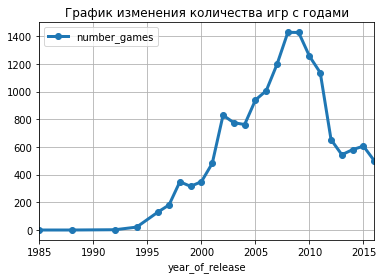

In [ ]:
data_grouped_year.plot(x='year_of_release', y='number_games', grid=True, linewidth=3, style='o-')
plt.title('График изменения количества игр с годами')
plt.show()

**Вывод**

По графику отчетливо видно, что начиная с 1994 года индустрия игр начила активно развиваться и достигла своего пика в 2008 году. За 2008 год в свет вышло 1427 игр. После количество игры выходимых за каждый последующий год начало сильно падать, пока не достигло минимума в 2013 году. Возможно это было связано выходом очень популярных игр, которые поглотили интерес пользователей на многие годы. Рынок игр меняется, поэтому для анализа не нужны данные за всё время.

### Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

Определим платформы с наибольшими суммарными продажами:

In [ ]:
top10_platform = data.pivot_table(index='platform', values='sum_sales', aggfunc='sum').sort_values(by ='sum_sales', ascending=False).head(10)
top10_platform = top10_platform.reset_index()
top10_platform

,platform,sum_sales
0,ps2,1233.56
1,x360,961.24
2,ps3,931.34
3,wii,891.18
4,ds,802.76
5,ps,596.53
6,ps4,314.14
7,gba,312.88
8,psp,289.53
9,3ds,257.81


In [ ]:
list_top10_platform = list(top10_platform['platform'])
list_top10_platform

['ps2', 'x360', 'ps3', 'wii', 'ds', 'ps', 'ps4', 'gba', 'psp', '3ds']

Создадим функцию для вывода сводной таблицы и графика изменения продаж и количества игр по годам для популярных платформ:

In [ ]:
def pivot_and_plot(platform, data):
    pivot = data[data['platform'] == platform].pivot_table(index='year_of_release', values='sum_sales', aggfunc=['count', 'sum'])
    pivot = pivot.reset_index()
    pivot.columns = ['year_of_release', 'number_of_games', 'total_sales']
    display(platform)
    display(pivot)
    
    ax = pivot.plot(x='year_of_release', y='number_of_games', grid=True, linewidth=3, style='o-')
    pivot.plot(x='year_of_release', y='total_sales', grid=True, linewidth=3, style='o-', ax=ax)
    plt.title('График изменения количества игр и продаж с годами')
    plt.show()

Отобразим изменение количества игр и продаж с годами для платформ с наибольшими суммарными продажами:

'ps2'

,year_of_release,number_of_games,total_sales
0,2000,82,39.17
1,2001,185,166.43
2,2002,280,205.38
3,2003,256,184.31
4,2004,259,211.81
5,2005,260,160.66
6,2006,259,103.42
7,2007,214,75.99
8,2008,191,53.90
9,2009,96,26.40


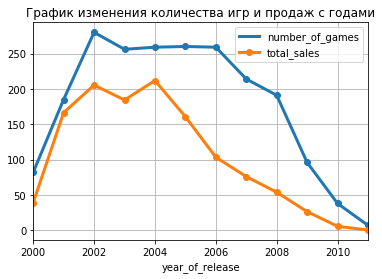

'x360'

,year_of_release,number_of_games,total_sales
0,2005,18,8.25
1,2006,93,51.62
2,2007,123,95.41
3,2008,146,135.26
4,2009,172,120.29
5,2010,182,170.03
6,2011,206,143.84
7,2012,106,99.74
8,2013,75,88.58
9,2014,63,34.74


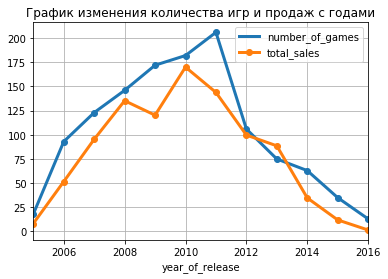

'ps3'

,year_of_release,number_of_games,total_sales
0,2006,27,20.96
1,2007,90,73.19
2,2008,138,118.52
3,2009,162,130.93
4,2010,181,142.17
5,2011,215,156.78
6,2012,148,107.36
7,2013,126,113.25
8,2014,108,47.76
9,2015,73,16.82


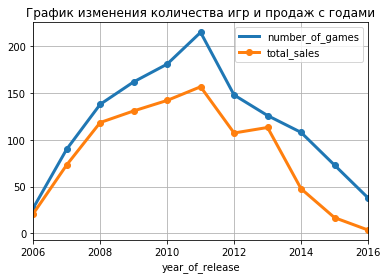

'wii'

,year_of_release,number_of_games,total_sales
0,2006,44,137.15
1,2007,185,152.77
2,2008,282,171.32
3,2009,325,206.97
4,2010,253,127.95
5,2011,143,59.65
6,2012,31,21.71
7,2013,12,8.59
8,2014,6,3.75
9,2015,4,1.14


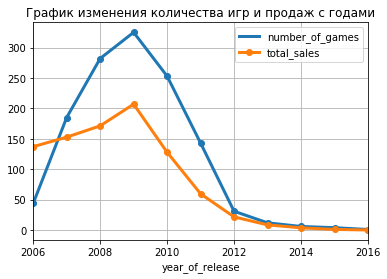

'ds'

,year_of_release,number_of_games,total_sales
0,2004,23,17.27
1,2005,118,130.14
2,2006,201,119.81
3,2007,376,146.94
4,2008,492,145.31
5,2009,403,119.54
6,2010,323,85.02
7,2011,153,26.18
8,2012,23,11.01
9,2013,8,1.54


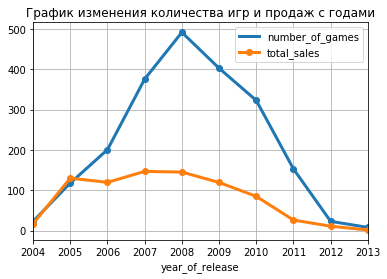

'ps'

,year_of_release,number_of_games,total_sales
0,1994,2,1.37
1,1996,79,60.79
2,1997,125,101.44
3,1998,225,157.48
4,1999,188,134.75
5,2000,160,96.37
6,2001,91,35.59
7,2002,20,6.67
8,2003,3,2.07


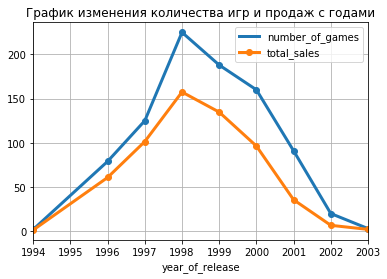

'ps4'

,year_of_release,number_of_games,total_sales
0,2013,16,25.99
1,2014,75,100.00
2,2015,137,118.90
3,2016,164,69.25


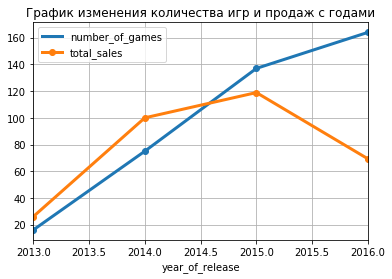

'gba'

,year_of_release,number_of_games,total_sales
0,2000,1,0.07
1,2001,107,61.53
2,2002,198,74.16
3,2003,150,56.67
4,2004,175,77.91
5,2005,135,33.86
6,2006,39,5.28
7,2007,6,3.40


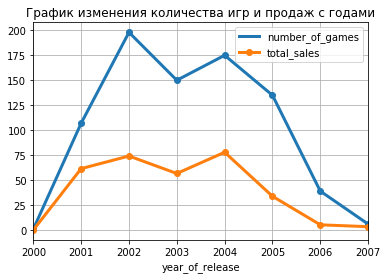

'psp'

,year_of_release,number_of_games,total_sales
0,2004,15,7.06
1,2005,95,43.84
2,2006,189,55.32
3,2007,133,46.93
4,2008,100,34.55
5,2009,161,37.78
6,2010,188,35.04
7,2011,139,17.82
8,2012,106,7.69
9,2013,54,3.14


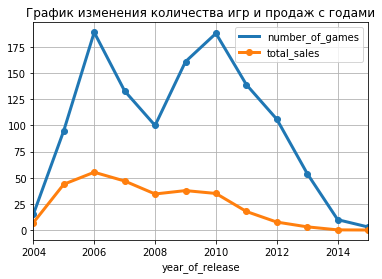

'3ds'

,year_of_release,number_of_games,total_sales
0,2011,116,63.20
1,2012,93,51.36
2,2013,91,56.57
3,2014,80,43.76
4,2015,86,27.78
5,2016,46,15.14


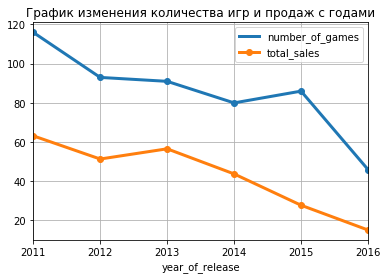

In [ ]:
for platform in list_top10_platform:
    pivot_and_plot(platform, data)

**Вывод**

Проанализировав графики легко заметить что практически все платформы в среднем являются актуальными в течении 10 лет и даже меньше, после на них игры перестают выпускать.

### Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.

In [ ]:
data_grouped_year = data.pivot_table(index='year_of_release', values='sum_sales', aggfunc='sum')
data_grouped_year = data_grouped_year.reset_index()
data_grouped_year.columns = ['year_of_release', 'sum_sales']
data_grouped_year.head()

,year_of_release,sum_sales
0,1985,0.04
1,1988,0.03
2,1992,0.28
3,1994,8.48
4,1996,125.48


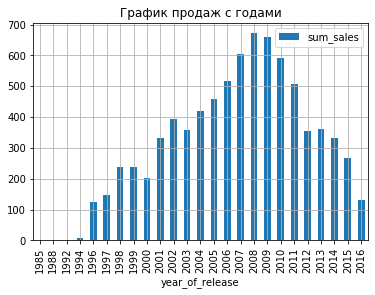

In [ ]:
data_grouped_year.plot(x='year_of_release', y='sum_sales', grid=True, linewidth=3, kind='bar')
plt.title('График продаж с годами')
plt.show()

По столбчатой диаграмме продаж видно, что стабилизация рынка произошла в 2012 году, но поскольку после 2013 года произошел еще один спад, то актуальным периодом для 2017 года являются данные за 2014-2016 года.

In [ ]:
actual_data = data[data['year_of_release'] >= 2014]
actual_data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
25,call of duty: black ops 3,ps4,2015,shooter,6.03,5.86,0.36,2.38,75.150000,6.070833,unknown,14.63
36,grand theft auto v,ps4,2014,action,3.96,6.31,0.38,1.97,97.000000,8.300000,m,12.62
40,pokemon omega ruby/pokemon alpha sapphire,3ds,2014,role-playing,4.35,3.49,3.10,0.74,72.042553,6.882000,unknown,11.68
66,fifa 16,ps4,2015,sports,1.12,6.12,0.06,1.28,82.000000,4.300000,e,8.58
76,star wars battlefront (2015),ps4,2015,shooter,2.99,3.49,0.22,1.28,75.150000,6.070833,unknown,7.98


In [ ]:
actual_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1688 entries, 25 to 15474
Data columns (total 12 columns):
name               1688 non-null object
platform           1688 non-null object
year_of_release    1688 non-null int64
genre              1688 non-null object
na_sales           1688 non-null float64
eu_sales           1688 non-null float64
jp_sales           1688 non-null float64
other_sales        1688 non-null float64
critic_score       1688 non-null float64
user_score         1688 non-null float64
rating             1688 non-null object
sum_sales          1688 non-null float64
dtypes: float64(7), int64(1), object(4)
memory usage: 171.4+ KB


Далее будем работать именно с актуальными для 2017 года данными.

### Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.

In [ ]:
top10_platform = actual_data.pivot_table(index='platform', values='sum_sales', aggfunc='sum').sort_values(by ='sum_sales', ascending=False).head(10)
top10_platform = top10_platform.reset_index()
top10_platform

,platform,sum_sales
0,ps4,288.15
1,xone,140.36
2,3ds,86.68
3,ps3,68.18
4,x360,48.22
5,wiiu,42.98
6,pc,27.05
7,psv,22.39
8,wii,5.07
9,psp,0.36


Значительно лидируют по продажам 2 платформы: ps4, xone.

In [ ]:
list_top10_platform = list(top10_platform['platform'])
list_top10_platform

['ps4', 'xone', '3ds', 'ps3', 'x360', 'wiiu', 'pc', 'psv', 'wii', 'psp']

'ps4'

,year_of_release,number_of_games,total_sales
0,2014,75,100.00
1,2015,137,118.90
2,2016,164,69.25


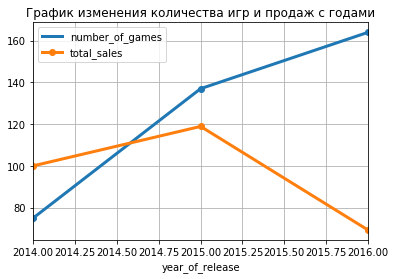

'xone'

,year_of_release,number_of_games,total_sales
0,2014,61,54.07
1,2015,80,60.14
2,2016,87,26.15


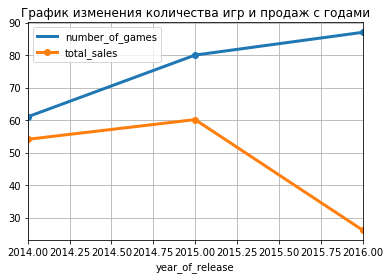

'3ds'

,year_of_release,number_of_games,total_sales
0,2014,80,43.76
1,2015,86,27.78
2,2016,46,15.14


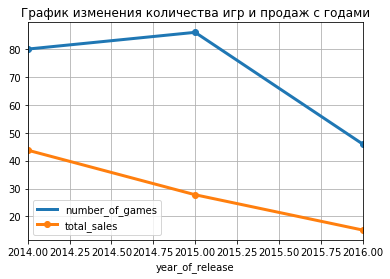

'ps3'

,year_of_release,number_of_games,total_sales
0,2014,108,47.76
1,2015,73,16.82
2,2016,38,3.60


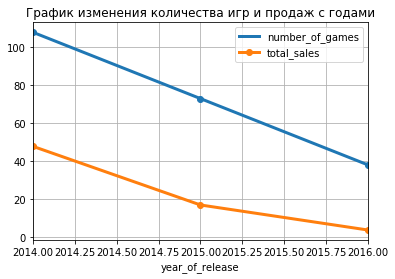

'x360'

,year_of_release,number_of_games,total_sales
0,2014,63,34.74
1,2015,35,11.96
2,2016,13,1.52


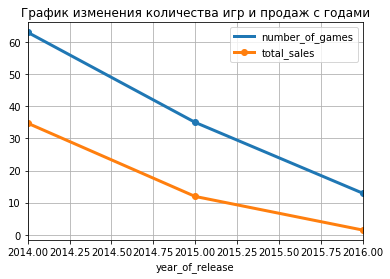

'wiiu'

,year_of_release,number_of_games,total_sales
0,2014,31,22.03
1,2015,28,16.35
2,2016,14,4.60


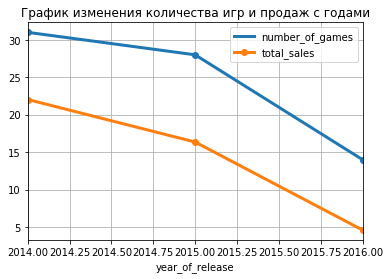

'pc'

,year_of_release,number_of_games,total_sales
0,2014,47,13.28
1,2015,50,8.52
2,2016,54,5.25


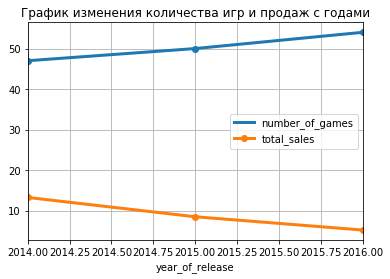

'psv'

,year_of_release,number_of_games,total_sales
0,2014,100,11.90
1,2015,110,6.25
2,2016,84,4.24


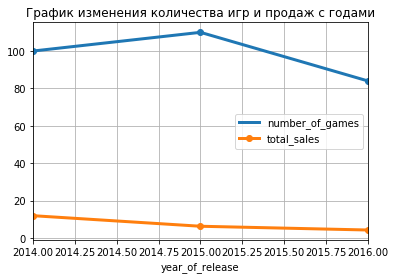

'wii'

,year_of_release,number_of_games,total_sales
0,2014,6,3.75
1,2015,4,1.14
2,2016,1,0.18


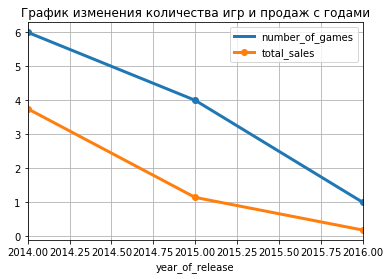

'psp'

,year_of_release,number_of_games,total_sales
0,2014,10,0.24
1,2015,3,0.12


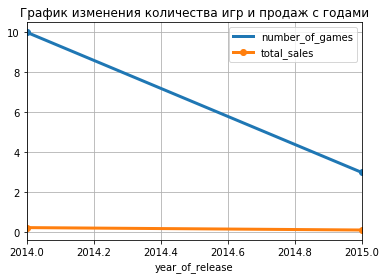

In [ ]:
for platform in list_top10_platform:
    pivot_and_plot(platform, actual_data)

**Вывод**

Из графиков очевидно что растут только 3 платформы: pc, ps4 и xone. 

### Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.

In [ ]:
actual_data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
25,call of duty: black ops 3,ps4,2015,shooter,6.03,5.86,0.36,2.38,75.150000,6.070833,unknown,14.63
36,grand theft auto v,ps4,2014,action,3.96,6.31,0.38,1.97,97.000000,8.300000,m,12.62
40,pokemon omega ruby/pokemon alpha sapphire,3ds,2014,role-playing,4.35,3.49,3.10,0.74,72.042553,6.882000,unknown,11.68
66,fifa 16,ps4,2015,sports,1.12,6.12,0.06,1.28,82.000000,4.300000,e,8.58
76,star wars battlefront (2015),ps4,2015,shooter,2.99,3.49,0.22,1.28,75.150000,6.070833,unknown,7.98


In [ ]:
top_actual_platform = ['pc', 'ps4', 'xone']

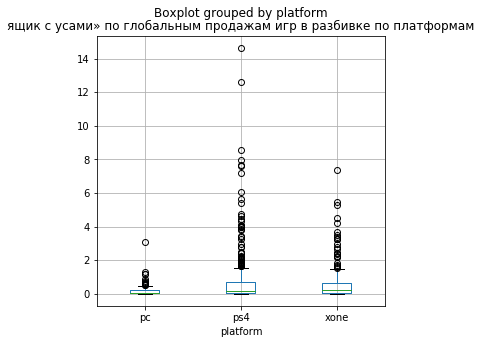

In [ ]:
actual_data.query('platform in @top_actual_platform').boxplot('sum_sales', by='platform', figsize=(5,5))
plt.title('ящик с усами» по глобальным продажам игр в разбивке по платформам')
plt.show()

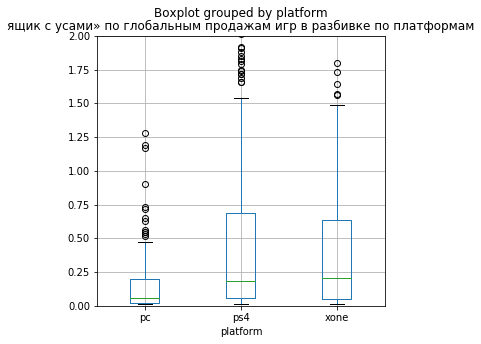

In [ ]:
actual_data.query('platform in @top_actual_platform').boxplot('sum_sales', by='platform', figsize=(5,5))
plt.ylim(0,2)
plt.title('ящик с усами» по глобальным продажам игр в разбивке по платформам')
plt.show()

Получим числовое описание:

In [ ]:
actual_data.query('platform in @top_actual_platform').groupby('platform')['sum_sales'].describe()

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
pc,151.0,0.179139,0.329359,0.01,0.0200,0.060,0.2000,3.05
ps4,376.0,0.766356,1.614969,0.01,0.0575,0.185,0.6900,14.63
xone,228.0,0.615614,1.046513,0.01,0.0500,0.205,0.6325,7.39


**Вывод**

По ящику с усами и числовому описанию можно сказать что продажи игр имеют очень большой разброс. Есть игры, которые были проданы в размере 0.01 млн копий, а есть игры которые были распространены в размере более 14 млн копий. 

### Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.

In [ ]:
top_actual_platform

['pc', 'ps4', 'xone']

In [ ]:
actual_data_new = actual_data.query('platform in @top_actual_platform')

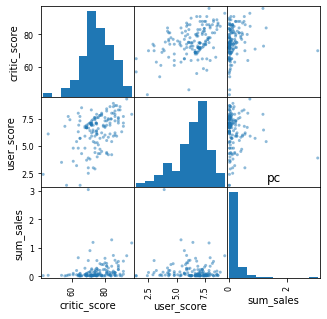

,critic_score,user_score,sum_sales
critic_score,1.000000,0.427336,0.185870
user_score,0.427336,1.000000,-0.098062
sum_sales,0.185870,-0.098062,1.000000


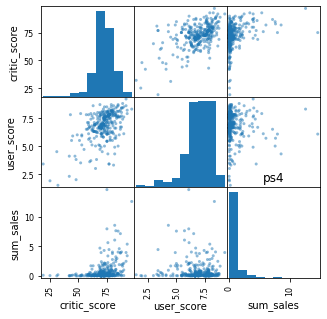

,critic_score,user_score,sum_sales
critic_score,1.000000,0.542497,0.324766
user_score,0.542497,1.000000,-0.070707
sum_sales,0.324766,-0.070707,1.000000


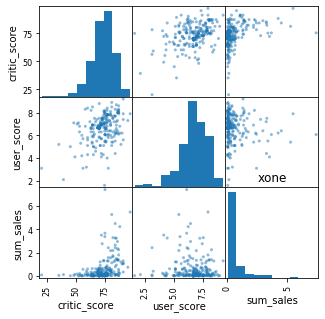

,critic_score,user_score,sum_sales
critic_score,1.000000,0.399033,0.381504
user_score,0.399033,1.000000,-0.080084
sum_sales,0.381504,-0.080084,1.000000


In [ ]:
for platform in top_actual_platform:
    data_platform = actual_data_new[actual_data_new['platform'] == platform]
    data_platform = data_platform[['critic_score', 'user_score', 'sum_sales']]
    pd.plotting.scatter_matrix(data_platform, figsize=(5,5))
    plt.title(platform)
    plt.show()
    display(data_platform.corr())

**Вывод**

По диаграммам рассеяния и матрицам корреляции видно, что есть небольшая зависимость между отзывами критиков и продажами. А вот между отзывами пользователей и продажами зависимость не наблюдается.

### Соотнесите выводы с продажами игр на других платформах.

Проделаем аналогичные действия из прошлого шага, но уже для всех платформ актуального датасета:

In [ ]:
actual_data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
25,call of duty: black ops 3,ps4,2015,shooter,6.03,5.86,0.36,2.38,75.150000,6.070833,unknown,14.63
36,grand theft auto v,ps4,2014,action,3.96,6.31,0.38,1.97,97.000000,8.300000,m,12.62
40,pokemon omega ruby/pokemon alpha sapphire,3ds,2014,role-playing,4.35,3.49,3.10,0.74,72.042553,6.882000,unknown,11.68
66,fifa 16,ps4,2015,sports,1.12,6.12,0.06,1.28,82.000000,4.300000,e,8.58
76,star wars battlefront (2015),ps4,2015,shooter,2.99,3.49,0.22,1.28,75.150000,6.070833,unknown,7.98


In [ ]:
actual_platform = list(actual_data['platform'].unique())
actual_platform

['ps4', '3ds', 'xone', 'wiiu', 'ps3', 'x360', 'pc', 'wii', 'psv', 'psp']

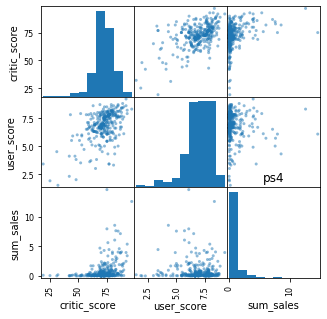

,critic_score,user_score,sum_sales
critic_score,1.000000,0.542497,0.324766
user_score,0.542497,1.000000,-0.070707
sum_sales,0.324766,-0.070707,1.000000


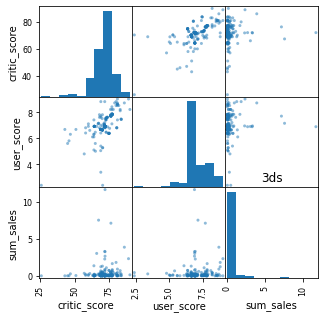

,critic_score,user_score,sum_sales
critic_score,1.000000,0.611528,0.083550
user_score,0.611528,1.000000,0.086873
sum_sales,0.083550,0.086873,1.000000


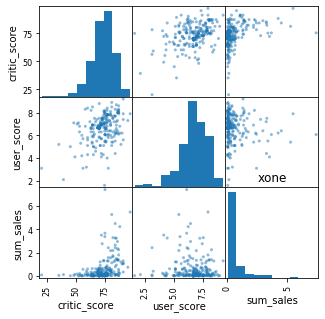

,critic_score,user_score,sum_sales
critic_score,1.000000,0.399033,0.381504
user_score,0.399033,1.000000,-0.080084
sum_sales,0.381504,-0.080084,1.000000


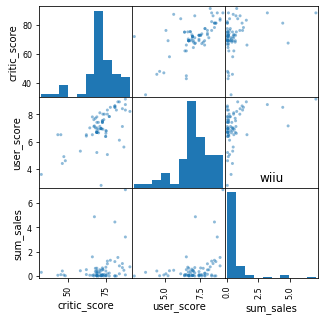

,critic_score,user_score,sum_sales
critic_score,1.000000,0.633460,0.278695
user_score,0.633460,1.000000,0.343099
sum_sales,0.278695,0.343099,1.000000


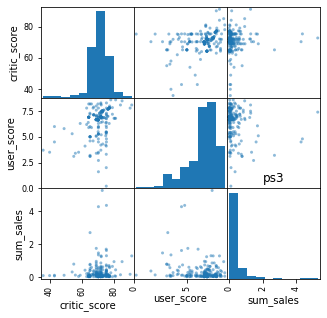

,critic_score,user_score,sum_sales
critic_score,1.000000,0.361847,0.086961
user_score,0.361847,1.000000,-0.174971
sum_sales,0.086961,-0.174971,1.000000


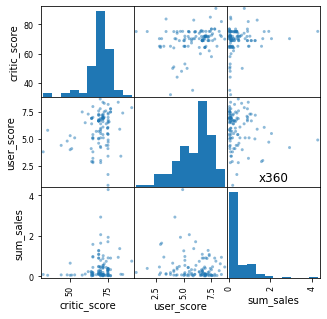

,critic_score,user_score,sum_sales
critic_score,1.000000,0.250233,0.176053
user_score,0.250233,1.000000,-0.155883
sum_sales,0.176053,-0.155883,1.000000


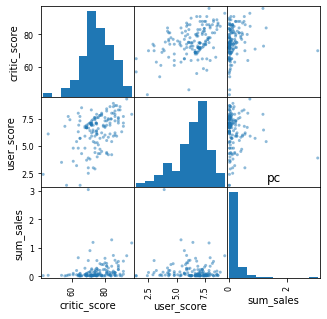

,critic_score,user_score,sum_sales
critic_score,1.000000,0.427336,0.185870
user_score,0.427336,1.000000,-0.098062
sum_sales,0.185870,-0.098062,1.000000


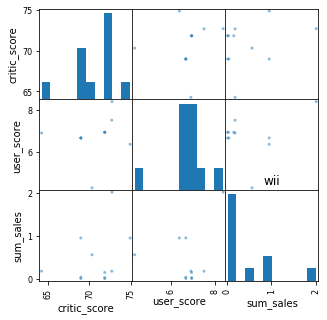

,critic_score,user_score,sum_sales
critic_score,1.000000,0.152899,0.321280
user_score,0.152899,1.000000,0.272399
sum_sales,0.321280,0.272399,1.000000


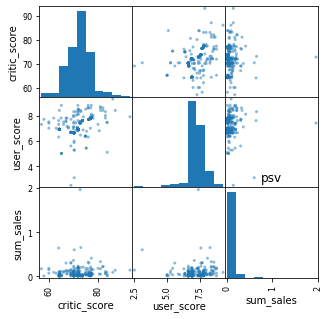

,critic_score,user_score,sum_sales
critic_score,1.000000,0.379994,0.035309
user_score,0.379994,1.000000,0.041694
sum_sales,0.035309,0.041694,1.000000


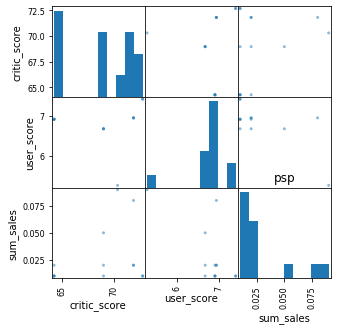

,critic_score,user_score,sum_sales
critic_score,1.000000,0.078236,0.299112
user_score,0.078236,1.000000,-0.681578
sum_sales,0.299112,-0.681578,1.000000


In [ ]:
for platform in actual_platform:
    data_platform = actual_data[actual_data['platform'] == platform]
    data_platform = data_platform[['critic_score', 'user_score', 'sum_sales']]
    pd.plotting.scatter_matrix(data_platform, figsize=(5,5))
    plt.title(platform)
    plt.show()
    display(data_platform.corr())

**Вывод**

В целом получили примерно такой же результат для всех платформ как и в предыдущем пункте.

### Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

In [ ]:
actual_data.pivot_table(index='genre', values='sum_sales', aggfunc='sum').sort_values(by='sum_sales', ascending=False)

,sum_sales
genre,
action,199.36
shooter,170.94
sports,109.48
role-playing,101.44
misc,37.55
fighting,28.22
racing,27.52
platform,18.09
adventure,17.55


**Вывод**

Самыми прибыльными жанрами являются: action, shooter, sports, role-playing. Это логично, поскольку именно в эти жанры играют большинство игроков.

## Составьте портрет пользователя каждого региона

Определите для пользователя каждого региона (NA, EU, JP):
- Самые популярные платформы (топ-5). Опишите различия в долях продаж.
- Самые популярные жанры (топ-5). Поясните разницу.
- Влияет ли рейтинг ESRB на продажи в отдельном регионе?

### Определим для пользователя каждого региона самые популярные платформы 

In [ ]:
actual_data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_sales
25,call of duty: black ops 3,ps4,2015,shooter,6.03,5.86,0.36,2.38,75.150000,6.070833,unknown,14.63
36,grand theft auto v,ps4,2014,action,3.96,6.31,0.38,1.97,97.000000,8.300000,m,12.62
40,pokemon omega ruby/pokemon alpha sapphire,3ds,2014,role-playing,4.35,3.49,3.10,0.74,72.042553,6.882000,unknown,11.68
66,fifa 16,ps4,2015,sports,1.12,6.12,0.06,1.28,82.000000,4.300000,e,8.58
76,star wars battlefront (2015),ps4,2015,shooter,2.99,3.49,0.22,1.28,75.150000,6.070833,unknown,7.98


In [ ]:
regions = ['na_sales', 'eu_sales', 'jp_sales']
for region in regions:
    display(region)
    display(actual_data.groupby('platform')[region].sum().sort_values(ascending=False).head())

'na_sales'

platform
ps4     98.61
xone    81.27
x360    28.30
3ds     22.64
ps3     22.05
Name: na_sales, dtype: float64

'eu_sales'

platform
ps4     130.04
xone     46.25
ps3      25.54
pc       17.97
3ds      16.12
Name: eu_sales, dtype: float64

'jp_sales'

platform
3ds     44.24
ps4     15.02
psv     14.54
ps3     11.22
wiiu     7.31
Name: jp_sales, dtype: float64

**Вывод**

Исходя из данных которые мы получили можно сделать вывод о том, что:
- в северной Америке самые популярные платформы: ps4, xone, x360, 3ds, ps3
- в Европе самые популярные платформы: ps4, xone, ps3, pc, 3ds
- в Японии самые популярные платформы: 3ds, ps4, psv, ps3, wiiu


### Определим для пользователя каждого региона самые популярные жанры

In [ ]:
for region in regions:
    display(region)
    display(actual_data.groupby('genre')[region].sum().sort_values(ascending=False).head())

'na_sales'

genre
shooter         79.02
action          72.53
sports          46.13
role-playing    33.47
misc            15.05
Name: na_sales, dtype: float64

'eu_sales'

genre
action          74.68
shooter         65.52
sports          45.73
role-playing    28.17
racing          14.13
Name: eu_sales, dtype: float64

'jp_sales'

genre
role-playing    31.16
action          29.58
fighting         6.37
misc             5.61
shooter          4.87
Name: jp_sales, dtype: float64

**Вывод**

- в северной Америке самые популярные жанры:  shooter, action,  sports, role-playing, misc 
- в Европе самые популярные жанры: action, shooter, sports, role-playing, racing
- в Японии самые популярные жанры: role-playing, action, fighting, misc, shooter

Жанры в Америке и Европе почти совпали. А вот для Японии не так интересен жанр shooter, как role_playing. 

### Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [ ]:
for region in regions:
    display(region)
    display(actual_data.groupby('rating')[region].sum().sort_values(ascending=False))

'na_sales'

rating
m          96.42
unknown    64.72
e          50.74
t          38.95
e10+       33.23
Name: na_sales, dtype: float64

'eu_sales'

rating
m          93.44
unknown    58.95
e          58.06
t          34.07
e10+       26.15
Name: eu_sales, dtype: float64

'jp_sales'

rating
unknown    56.90
t          14.78
e           8.94
m           8.01
e10+        4.46
Name: jp_sales, dtype: float64

**Вывод**

В Америке и Европе вкусы вновь совпали. Пользователям этих стран больше всего нравятся игры рейтинга M, а вот в Японии в топ вышел неизвестный нам рейтинг, возможно ситуация изменилась бы, если рейтинги были заполнены, а не пропущены. 

## Проверка гипотез:

- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

### Проверка гипотезы: средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Сформулируем нулевую и альтернативную гипотезы.

Нулевая гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC равны

Альтернативная гипотеза: Средние пользовательские рейтинги платформ Xbox One и PC не равны

Подготовим выборки для проверки гипотезы:

In [ ]:
xone = actual_data[actual_data['platform'] == 'xone']
pc = actual_data[actual_data['platform'] == 'pc']

Проверим дисперсии выборок:

In [ ]:
display(np.var(xone['user_score'], ddof=1))
display(np.var(pc['user_score'], ddof=1))

1.4806860711778114

2.43541911757782

Дисперсии выборок разные, необходимо установить equal_var = False

Отобразим распределение выборок:

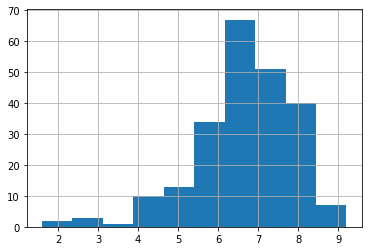

In [ ]:
display(xone['user_score'].hist(bins=10))

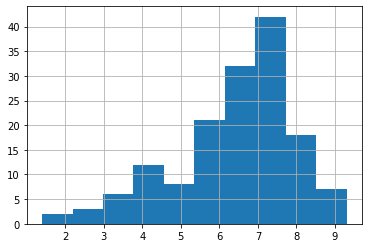

In [ ]:
display(pc['user_score'].hist(bins=10))

Создадим функцию для удобного проведения t-теста:

In [ ]:
def stat_test(data1, data2, equal):
    alpha = 0.05 # критический уровень статистической значимости
    # если p-value окажется меньше него - отвергнем гипотезу

    results = st.ttest_ind(data1, data2, equal_var=equal)

    print('p-значение: ', results.pvalue)

    if results.pvalue < alpha:
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу") 

Проведем статистический тест:

In [ ]:
stat_test(xone['user_score'], pc['user_score'], False)

p-значение:  0.13148435600856584
Не получилось отвергнуть нулевую гипотезу


**Вывод**

Нельзя отвергать гипотезу о том, что cредние пользовательские рейтинги платформ Xbox One и PC равны.

### Проверка гипотезы: средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные

Сформулируем нулевую и альтернативную гипотезы.

Нулевая гипотеза: средние пользовательские рейтинги жанров Action и Sports равны

Альтернативная гипотеза: средние пользовательские рейтинги жанров Action и Sports не равны

Подготовим выборки для проверки гипотез:

In [ ]:
action = actual_data[actual_data['genre'] == 'action']
sports = actual_data[actual_data['genre'] == 'sports']

Проверим дисперсии выборок:

In [ ]:
display(np.var(action['user_score'], ddof=1))
display(np.var(sports['user_score'], ddof=1))

0.9201438888726473

2.721752916403897

Дисперсии выборок отличаются, поэтому equal_var = False

Отобразим распределение выборок:

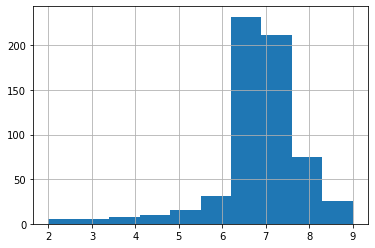

In [ ]:
display(action['user_score'].hist(bins=10))

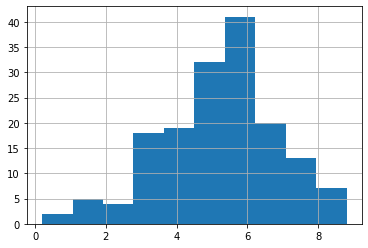

In [ ]:
display(sports['user_score'].hist(bins=10))

Проведем статистический тест:

In [ ]:
stat_test(action['user_score'], sports['user_score'], False)

p-значение:  2.50081542259587e-23
Отвергаем нулевую гипотезу


**Вывод**

Нулевая гипотеза отвергнута.
Нельзя отвергать гипотезу о том, что средние пользовательские рейтинги жанров Action и Sports разные.

## Вывод

В этом проекте нам необходимо было поработать с датасетом об играх. В таблице была информация о названии игры, платформе, жанре, годе игры, продажах в разных странах и оценках.

Мы начали свое исследование с тщательной предобработки данных. Выявили такие проблемы как пропуски, неудобные типы данных. Проблемы были устранены и мы перешли к дальнейшему анализу.

Сначала мы добавили столбец с суммарными продажами игры по всему миру.

**Исследование показало:**

Начиная с 1994 года индустрия игр начила активно развиваться и достигла своего пика в 2008 году. За 2008 год в свет вышло 1427 игр. После количество игры выходимых за каждый последующий год начало сильно падать, пока не достигло минимума в 2013 году. Возможно это было связано выходом очень популярных игр, которые поглотили интерес пользователей на многие годы. Рынок игр меняется, поэтому для анализа не нужны данные за всё время.

Также мы выяснили, что в среднем игровые платформы актуальны не более 10 лет, далее их заменяют более новые версии, но что еще важнее бурные продажи игр уравновесились лишь в 2014 году. Поэтому для прогнозирования 2017 года мы использовали данные с 2014 по 2016 года.

Из актуального набора данных мы выделили лишь 3 платформы, которые к 2016 году развиваются или активны: pc, ps4, xone.

Далее определили для каждого региона самые популярные платформы, самые популярные жанры.


**Проверка гипотез:**
В проекте необходимо было проверить 2 гипотезы:
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.
Мы подготовили данные и провели статистические тесты с этими выборками. Результаты статистических тестов показали:
- нельзя отвергать гипотезу о том, что cредние пользовательские рейтинги платформ Xbox One и PC равны.
- нельзя отвергать гипотезу о том, что средние пользовательские рейтинги жанров Action и Sports разные.